In [72]:
#Instalando os complementos necessários
!pip install seaborn -q
!pip install category_encoders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [87]:
#Importando as bibliotecas necessarias para a realização do trabalho
import requests as r
import csv
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import openpyxl
from statistics import mean
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error, accuracy_score, f1_score, \
precision_score, recall_score, roc_auc_score, r2_score
from sklearn.model_selection import train_test_split, KFold, cross_val_score, \
StratifiedKFold, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from category_encoders import OrdinalEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

In [81]:
#Conectando ao Google Drive para acessar a base de dados.
from google.colab import drive
drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


In [85]:
#Removendo UF do nome do município.
#Abrindo o arquivo Excel
workbook = openpyxl.load_workbook(r"/content/drive/MyDrive/TCC2023/Excel/IDH2010AB.xlsx")

#Selecionando a Planilha
worksheet = workbook['Worksheet']

#Iterando pelas células na coluna A a partir da segunda linha pois a primeira é o cabeçalho
for row in worksheet.iter_rows(min_row=2, min_col=1):
    cell = row[0]
    # obtém o valor da célula como uma string
    value = str(cell.value)
    # remove as cinco últimas letras da string
    new_value = value[:-5]
    # atualiza o valor da célula com a nova string
    cell.value = new_value

#Salvando o arquivo Excel com as alterações
workbook.save(r"/content/drive/MyDrive/TCC2023/Excel/IDH2010AB_C.xlsx")


In [86]:
#Carregando a planilha como DataFrame
IDH = (r"/content/drive/MyDrive/TCC2023/Excel/IDH2010AB_C.xlsx")
idh_df = pd.read_excel(IDH)

In [90]:
"""A planilha com dados mais atualizados de IDH é de 2010 disponível no atlas brasil.
Já as planilhas de produtividade por cultura são entre o período de 2017 a 2020."""

#Checando se a planilha foi carregada corretamente e os dados disponíveis nela.
idh_df.head()

,Municipio,Posição IDHM,IDHM,Posição IDHM Renda,IDHM Renda,Posição IDHM Educação,IDHM Educação,Posição IDHM Longevidade,IDHM Longevidade
0,São Caetano do Sul,1,0.862,1,0.891,2,0.811,19,0.887
1,Águas de São Pedro,2,0.854,12,0.849,1,0.825,11,0.890
2,Florianópolis,3,0.847,5,0.870,5,0.800,147,0.873
3,Vitória,4,0.845,3,0.876,4,0.805,551,0.855
4,Balneário Camboriú,4,0.845,10,0.854,6,0.789,1,0.894


In [84]:
#Obtendo uma visão geral do DataFrame. Assim é possivel analisar o número de linhas e colunas, a quantidade de valores não nulos em cada coluna e o tipo de dado armazenado em cada coluna.
idh_df
print(idh_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5565 entries, 0 to 5564
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Municipio                 5565 non-null   object 
 1   Posição IDHM              5565 non-null   int64  
 2   IDHM                      5565 non-null   float64
 3   Posição IDHM Renda        5565 non-null   int64  
 4   IDHM Renda                5565 non-null   float64
 5   Posição IDHM Educação     5565 non-null   int64  
 6   IDHM Educação             5565 non-null   float64
 7   Posição IDHM Longevidade  5565 non-null   int64  
 8   IDHM Longevidade          5565 non-null   float64
dtypes: float64(4), int64(4), object(1)
memory usage: 391.4+ KB
None


In [80]:
idh_df

,Municipio,Posição IDHM,IDHM,Posição IDHM Renda,IDHM Renda,Posição IDHM Educação,IDHM Educação,Posição IDHM Longevidade,IDHM Longevidade
0,São Caetano Do Sul,1,0.862,1,0.891,2,0.811,19,0.887
1,Águas De São Pedro,2,0.854,12,0.849,1,0.825,11,0.890
2,Florianópolis,3,0.847,5,0.870,5,0.800,147,0.873
3,Vitória,4,0.845,3,0.876,4,0.805,551,0.855
4,Balneário Camboriú,4,0.845,10,0.854,6,0.789,1,0.894
...,...,...,...,...,...,...,...,...,...
5560,Uiramutã,5560,0.453,5559,0.439,5561,0.276,4272,0.766
5561,Marajá Do Sena,5562,0.452,5565,0.400,5554,0.299,3987,0.774
5562,Atalaia Do Norte,5563,0.450,5506,0.481,5563,0.259,5094,0.733
5563,Fernando Falcão,5564,0.443,5563,0.417,5556,0.286,5175,0.728


In [11]:
#Filtrando as colunas de interesse.
idh_df.loc[:, 'Municipio'] = idh_df['Municipio'].str.title()
idhf_df=idh_df[['Municipio','IDHM']]
idhf_df.head()

,Municipio,IDHM
0,São Caetano Do Sul,0.862
1,Águas De São Pedro,0.854
2,Florianópolis,0.847
3,Vitória,0.845
4,Balneário Camboriú,0.845


In [12]:
#Carregando o Dataframe com os dados de produção da Soja
soja = (r"/content/drive/MyDrive/TCC2023/Excel/Soja.xlsx")
soja = pd.read_excel(soja)
#Filtrando as colunas de interesse.
soja.loc[:, 'Municipio'] = soja['Municipio'].str.title()
soja_df=soja[['Municipio','Produtividade']]
soja_df.head()

,Municipio,Produtividade
0,Alta Floresta D'Oeste,1350.0
1,Ariquemes,25497.0
2,Cabixi,86772.0
3,Cacoal,3000.0
4,Cerejeiras,140760.0


In [13]:
#Carregando o Dataframe com os dados de produção do Milho
milho = (r"/content/drive/MyDrive/TCC2023/Excel/Milho.xlsx")
milho = pd.read_excel(milho)
#Filtrando as colunas de interesse.
milho.loc[:, 'Municipio'] = milho['Municipio'].str.title()
milho_df=milho[['Municipio','Produtividade']]
milho_df.head()

,Municipio,Produtividade
0,Alta Floresta D'Oeste,16267.0
1,Ariquemes,5760.0
2,Cabixi,93920.0
3,Cacoal,3616.0
4,Cerejeiras,147360.0


In [14]:
#Carregando o Dataframe com os dados de produção do Café
cafe = (r"/content/drive/MyDrive/TCC2023/Excel/Café.xlsx")
cafe = pd.read_excel(cafe)
#Filtrando as colunas de interesse.
cafe.loc[:, 'Municipio'] = cafe['Municipio'].str.title()
cafe_df=cafe[['Municipio','Produtividade']]
cafe_df.head()

,Municipio,Produtividade
0,Jussari,57
1,Alto Caparaó,3889
2,Sabará,6
3,Alta Floresta D'Oeste,4798
4,Ariquemes,294


In [15]:
#Carregando o Dataframe com os dados de produção da Cana-de-Açucar
cana = (r"/content/drive/MyDrive/TCC2023/Excel/Cana.xlsx")
cana = pd.read_excel(cana)
#Filtrando as colunas de interesse.
cana.loc[:, 'Municipio'] = cana['Municipio'].str.title()
cana_df=cana[['Municipio','Produtividade']]
cana_df.head()

,Municipio,Produtividade
0,Alta Floresta D'Oeste,300.0
1,Ariquemes,721.0
2,Cabixi,1500.0
3,Cacoal,1000.0
4,Cerejeiras,7000.0


In [16]:
#Carregando o Dataframe com os dados de produção do Trigo
trigo = (r"/content/drive/MyDrive/TCC2023/Excel/Trigo.xlsx")
trigo = pd.read_excel(trigo)
#Filtrando as colunas de interesse.
trigo.loc[:, 'Municipio'] = trigo['Municipio'].str.title()
trigo_df=trigo[['Municipio','Produtividade']]
trigo_df.head()

,Municipio,Produtividade
0,Água Fria De Goiás,7615
1,Antônio João,868
2,Victor Graeff,12356
3,Soledade,5524
4,Sertão,12463


In [17]:
#Carregando o Dataframe com os dados de produção do Algodão
algodao = (r"/content/drive/MyDrive/TCC2023/Excel/Algodão.xlsx")
algodao = pd.read_excel(algodao)
#Filtrando as colunas de interesse.
algodao.loc[:, 'Municipio'] = algodao['Municipio'].str.title()
algodao_df=algodao[['Municipio','Produtividade']]
algodao_df.head()

,Municipio,Produtividade
0,Perolândia,3553
1,Costa Rica,92603
2,Serra Talhada,2
3,Canindé,7
4,Acopiara,41


In [18]:
#Obtendo uma visão geral de cada DataFrame. Assim é possivel analisar o número de linhas e colunas, a quantidade de valores não nulos em cada coluna e o tipo de dado armazenado em cada coluna.
print(soja_df.info())
print(milho_df.info())
print(cafe_df.info())
print(trigo_df.info())
print(cana_df.info())
print(algodao_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2388 entries, 0 to 2387
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Municipio      2388 non-null   object 
 1   Produtividade  2388 non-null   float64
dtypes: float64(1), object(1)
memory usage: 37.4+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5104 entries, 0 to 5103
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Municipio      5104 non-null   object 
 1   Produtividade  5104 non-null   float64
dtypes: float64(1), object(1)
memory usage: 79.9+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1212 entries, 0 to 1211
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Municipio      1212 non-null   object
 1   Produtividade  1212 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 

In [20]:
#Checando se os dado estão em formado DataFrame
print(type(idhf_df))
print(type(soja_df))
print(type(milho_df))
print(type(trigo_df))
print(type(cafe_df))
print(type(cana_df))
print(type(algodao_df))

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>


In [21]:
# Carregando as seis planilhas do Excel em um dicionário
planilhas = {}
for cultivo in ['Soja', 'Café', 'Milho', 'Cana', 'Trigo', 'Algodão']:
    planilhas[cultivo] = pd.read_excel(f"/content/drive/MyDrive/TCC2023/Excel/{cultivo}.xlsx", sheet_name='Worksheet')
    
# Selecionando apenas a coluna desejada em cada planilha e renomeiando para o nome do cultivo
colunas_selecionadas = {}
for cultivo in ['Soja', 'Café', 'Milho', 'Cana', 'Trigo', 'Algodão']:
    colunas_selecionadas[cultivo] = planilhas[cultivo][['Municipio', 'Produtividade']].rename(columns={'Produtividade': cultivo})

# Criando a nova planilha com base na coluna 'Municipio'
nova_planilha = pd.DataFrame(colunas_selecionadas['Soja']['Municipio'])
for cultivo in ['Soja', 'Café', 'Milho', 'Cana', 'Trigo', 'Algodão']:
    nova_planilha[cultivo] = colunas_selecionadas[cultivo][cultivo]

# Salvando a nova planilha em um arquivo Excel
nova_planilha.to_excel(r"/content/drive/MyDrive/TCC2023/Excel/Colunas_selecionadas.xlsx", index=False)


In [50]:
#Renomeando as Colunas para facil entendimento posteriormente
prod_comb = (r"/content/drive/MyDrive/TCC2023/Excel/Colunas_selecionadas.xlsx")
prod_comb_df = pd.read_excel(prod_comb)
prod_comb_df = prod_comb_df.rename(columns={'Soja': 'Prod_Soja', 'Café': 'Prod_Cafe', 'Milho': 'Prod_Milho', 'Cana': 'Prod_Cana', 'Trigo': 'Prod_Trigo', 'Algodão': 'Prod_Algodao' })
prod_comb_df.head()

,Municipio,Prod_Soja,Prod_Cafe,Prod_Milho,Prod_Cana,Prod_Trigo,Prod_Algodao
0,Alta Floresta D'Oeste,1350.0,57.0,16267.0,300.0,7615.0,3553.0
1,Ariquemes,25497.0,3889.0,5760.0,721.0,868.0,92603.0
2,Cabixi,86772.0,6.0,93920.0,1500.0,12356.0,2.0
3,Cacoal,3000.0,4798.0,3616.0,1000.0,5524.0,7.0
4,Cerejeiras,140760.0,294.0,147360.0,7000.0,12463.0,41.0


In [51]:
#Criando uma coluna com a soma total das produtividades das culturas selecionadas por municipio
prod_comb_df['Total_Prod'] = prod_comb_df[['Prod_Soja', 'Prod_Cafe', 'Prod_Milho', 'Prod_Cana', 'Prod_Trigo', 'Prod_Algodao']].sum(axis=1)
prod_comb_df.head()

,Municipio,Prod_Soja,Prod_Cafe,Prod_Milho,Prod_Cana,Prod_Trigo,Prod_Algodao,Total_Prod
0,Alta Floresta D'Oeste,1350.0,57.0,16267.0,300.0,7615.0,3553.0,29142.0
1,Ariquemes,25497.0,3889.0,5760.0,721.0,868.0,92603.0,129338.0
2,Cabixi,86772.0,6.0,93920.0,1500.0,12356.0,2.0,194556.0
3,Cacoal,3000.0,4798.0,3616.0,1000.0,5524.0,7.0,17945.0
4,Cerejeiras,140760.0,294.0,147360.0,7000.0,12463.0,41.0,307918.0


In [77]:
#Unir o dataframe IDHM com o de Produção

IDHM_Prod_df = pd.merge(prod_comb_df, idhf_df, on='Municipio')

#Checando o resultado da união
IDHM_Prod_df

,Municipio,Prod_Soja,Prod_Cafe,Prod_Milho,Prod_Cana,Prod_Trigo,Prod_Algodao,Total_Prod,IDHM
0,Alta Floresta D'Oeste,1350.0,57.0,16267.0,300.0,7615.0,3553.0,29142.0,0.641
1,Ariquemes,25497.0,3889.0,5760.0,721.0,868.0,92603.0,129338.0,0.702
2,Cabixi,86772.0,6.0,93920.0,1500.0,12356.0,2.0,194556.0,0.650
3,Cacoal,3000.0,4798.0,3616.0,1000.0,5524.0,7.0,17945.0,0.718
4,Cerejeiras,140760.0,294.0,147360.0,7000.0,12463.0,41.0,307918.0,0.692
...,...,...,...,...,...,...,...,...,...
2093,Vianópolis,154980.0,NaN,916.0,1344.0,NaN,NaN,157240.0,0.712
2094,Vicentinópolis,73500.0,NaN,255.0,60.0,NaN,NaN,73815.0,0.684
2095,Vila Boa,900.0,NaN,307.0,328500.0,NaN,NaN,329707.0,0.647
2096,Vila Propício,45090.0,NaN,1463.0,260.0,NaN,NaN,46813.0,0.634


In [53]:
#Detectando valores ausentes.
print(IDHM_Prod_df.isnull().sum())
print(IDHM_Prod_df.isna().sum())
print(IDHM_Prod_df.info())

Municipio          0
Prod_Soja          0
Prod_Cafe       1002
Prod_Milho         0
Prod_Cana          0
Prod_Trigo      1626
Prod_Algodao    2006
Total_Prod         0
IDHM               0
dtype: int64
Municipio          0
Prod_Soja          0
Prod_Cafe       1002
Prod_Milho         0
Prod_Cana          0
Prod_Trigo      1626
Prod_Algodao    2006
Total_Prod         0
IDHM               0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2098 entries, 0 to 2097
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Municipio     2098 non-null   object 
 1   Prod_Soja     2098 non-null   float64
 2   Prod_Cafe     1096 non-null   float64
 3   Prod_Milho    2098 non-null   float64
 4   Prod_Cana     2098 non-null   float64
 5   Prod_Trigo    472 non-null    float64
 6   Prod_Algodao  92 non-null     float64
 7   Total_Prod    2098 non-null   float64
 8   IDHM          2098 non-null   float64
dtypes: float64(8

In [54]:
#Resumo estatístico do DataFrame, incluindo contagem, média, desvio padrão, valor mínimo, valor máximo e quartis (25%, 50% e 75%) para cada coluna numérica
IDHM_Prod_df.describe()

,Prod_Soja,Prod_Cafe,Prod_Milho,Prod_Cana,Prod_Trigo,Prod_Algodao,Total_Prod,IDHM
count,2.098000e+03,1096.000000,2098.000000,2.098000e+03,472.000000,92.000000,2.098000e+03,2098.000000
mean,5.052945e+04,1922.036496,6237.684938,2.564814e+05,6445.942797,15754.923913,3.163936e+05,0.697342
std,1.362236e+05,4497.035583,29971.627148,6.725576e+05,10050.094631,40653.326787,7.019175e+05,0.056535
min,3.000000e+00,1.000000,1.000000,1.000000e+00,21.000000,1.000000,4.610000e+02,0.443000
25%,1.917000e+03,16.000000,108.000000,5.000000e+02,948.250000,4.000000,1.244400e+04,0.670000
50%,9.600000e+03,177.500000,400.000000,2.730000e+03,3068.500000,17.500000,4.753150e+04,0.707000
75%,4.399875e+04,1640.500000,1911.000000,1.236438e+05,7668.750000,7236.000000,2.377732e+05,0.737000
max,2.283300e+06,55135.000000,627366.000000,7.975320e+06,80231.000000,285222.000000,7.976595e+06,0.827000


"A seguir, podemos observar as categorias sob as quais são divididos as cidades com base em seus respectivos IDHs:
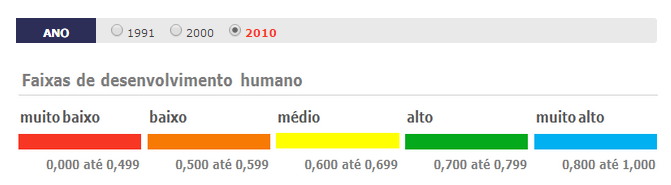

Dessa forma criei uma nova coluna, IDHM_Faixa, separando o IDHM por faixas correspondentes.

In [78]:
#Incluindo uma coluna com uma variável categórica para posterior uso no modelo Decision Tree Classifier.
dicionario_faixas  ={0: [0.0, 0.499], 1: [0.5, 0.599], 2:[0.6, 0.699], 3:[0.7,0.799], 4:[0.8,1.0]}
IDHM_Prod_df['IDHM_Faixa'] = 0
for faixa in dicionario_faixas:
  limitante = dicionario_faixas[faixa]
  IDHM_Prod_df.loc[(IDHM_Prod_df.IDHM >= limitante[0])&(IDHM_Prod_df.IDHM < limitante[1]), 'IDHM_Faixa'] = faixa
IDHM_Prod_df.loc[:, ['IDHM_Faixa','Municipio' ]].groupby(by= ['IDHM_Faixa']).count()
IDHM_Prod_df

,Municipio,Prod_Soja,Prod_Cafe,Prod_Milho,Prod_Cana,Prod_Trigo,Prod_Algodao,Total_Prod,IDHM,IDHM_Faixa
0,Alta Floresta D'Oeste,1350.0,57.0,16267.0,300.0,7615.0,3553.0,29142.0,0.641,2
1,Ariquemes,25497.0,3889.0,5760.0,721.0,868.0,92603.0,129338.0,0.702,3
2,Cabixi,86772.0,6.0,93920.0,1500.0,12356.0,2.0,194556.0,0.650,2
3,Cacoal,3000.0,4798.0,3616.0,1000.0,5524.0,7.0,17945.0,0.718,3
4,Cerejeiras,140760.0,294.0,147360.0,7000.0,12463.0,41.0,307918.0,0.692,2
...,...,...,...,...,...,...,...,...,...,...
2093,Vianópolis,154980.0,NaN,916.0,1344.0,NaN,NaN,157240.0,0.712,3
2094,Vicentinópolis,73500.0,NaN,255.0,60.0,NaN,NaN,73815.0,0.684,2
2095,Vila Boa,900.0,NaN,307.0,328500.0,NaN,NaN,329707.0,0.647,2
2096,Vila Propício,45090.0,NaN,1463.0,260.0,NaN,NaN,46813.0,0.634,2


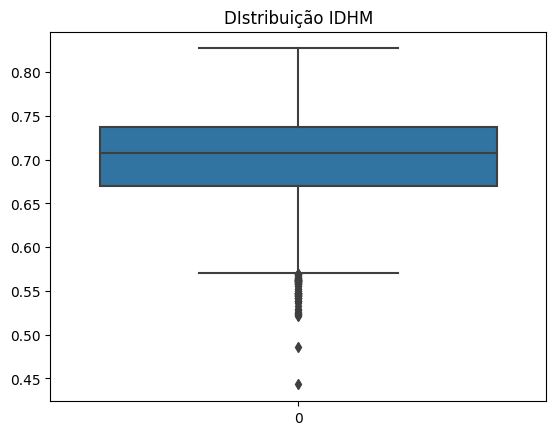

In [56]:
#Selecionando a coluna de dados de Produção Total
IDHM_df = IDHM_Prod_df['IDHM']

#Criando o boxplot usando a função boxplot() do Seaborn
sns.boxplot(data=IDHM_df)

#Adicionando títulos e rótulos aos eixos
plt.title('DIstribuição IDHM')

#Mostrando o gráfico
plt.show()

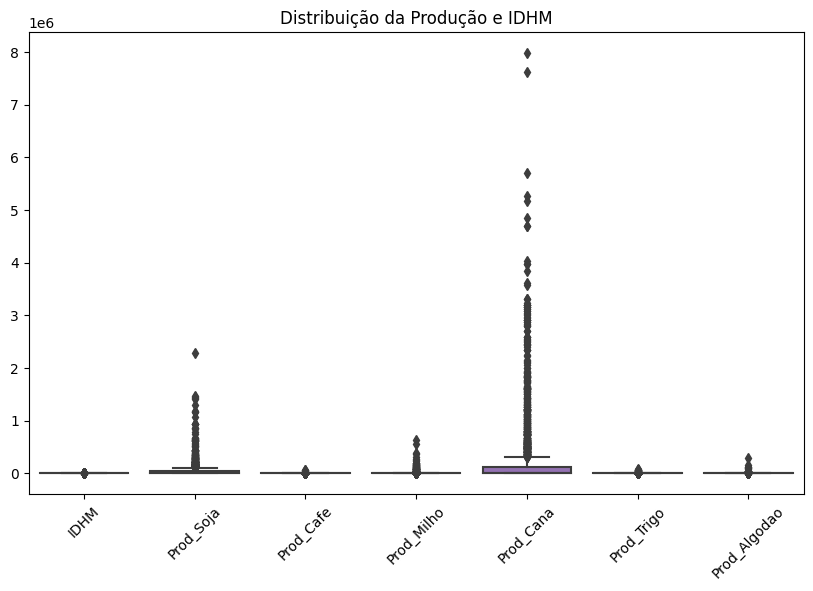

In [73]:
#Selecionando as colunas de interesse
cols = ['IDHM', 'Prod_Soja', 'Prod_Cafe', 'Prod_Milho', 'Prod_Cana', 'Prod_Trigo', 'Prod_Algodao']
df_box = IDHM_Prod_df[cols]

#Criando o boxplot
fig, ax = plt.subplots(figsize=(10,6))
sns.boxplot(data=df_box, ax=ax)
plt.xticks(rotation=45)
plt.title('Distribuição da Produção e IDHM')

#Mostrando o gráfico
plt.show()

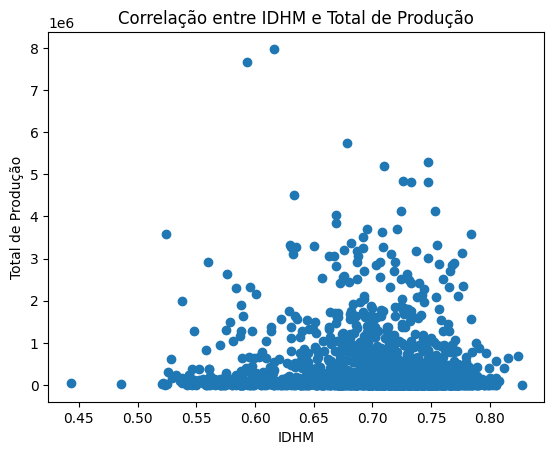

In [74]:
#Total de Produtividade por Município correlacionado com IDHM

#Criando o grafico de dispersão
plt.scatter(IDHM_Prod_df['IDHM'], IDHM_Prod_df['Total_Prod'])
plt.title('Correlação entre IDHM e Total de Produção')
plt.xlabel('IDHM')
plt.ylabel('Total de Produção')

#Mostrando o gráfico
plt.show()

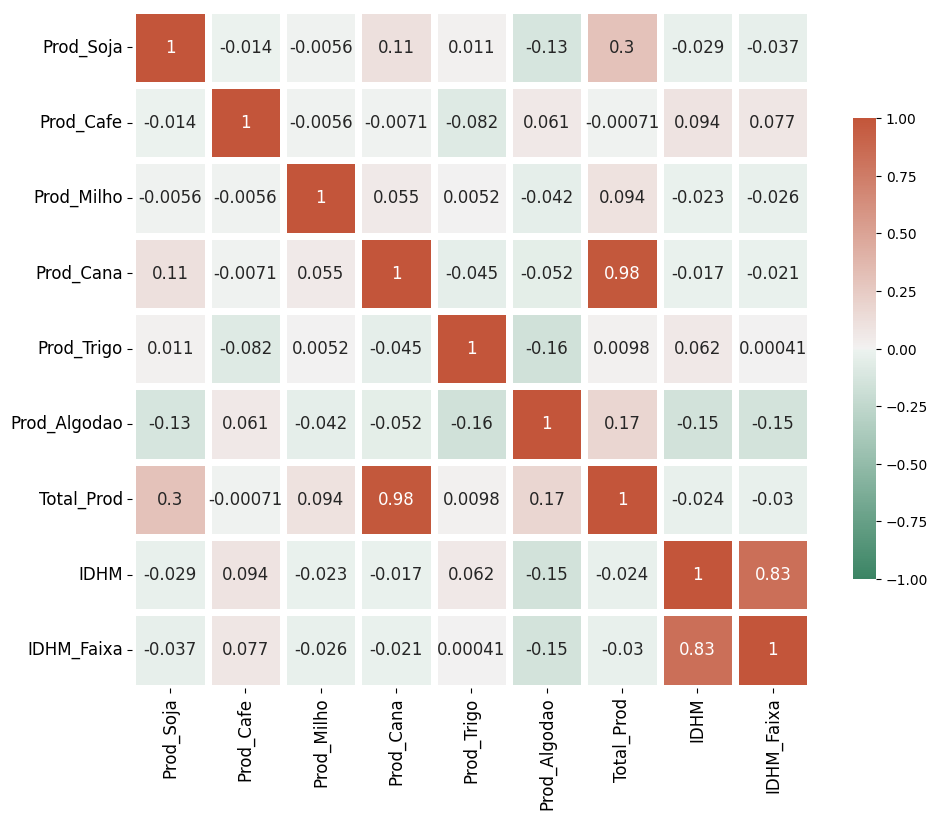

In [59]:
#Criando um gráfico de correlação para analisar a relação entre duas variáveis em um conjunto de dados, mostrando a intensidade e direção da correlação entre elas.

corr = IDHM_Prod_df.corr()
plt.figure(figsize=(10, 10))
cmap = sns.diverging_palette(150, 20, as_cmap=True)
graph = sns.heatmap(corr, cmap=cmap, center=0, vmin=-1, vmax=1, annot=True, square=True,
                    linewidths=5, cbar_kws={'shrink': 0.5}, annot_kws={'size': 12})
graph.set_xticklabels(graph.get_xmajorticklabels(), fontsize=12)
graph.set_yticklabels(graph.get_ymajorticklabels(), fontsize=12)

#Mostrando o gráfico
plt.tight_layout()

In [60]:
#Mostrando as informações do gráfico de correlação acima como texto
correlacao = IDHM_Prod_df[['IDHM', 'Prod_Soja', 'Prod_Cafe', 'Prod_Milho', 'Prod_Cana', 'Prod_Trigo', 'Prod_Algodao']].corr()
print(correlacao)

                  IDHM  Prod_Soja  Prod_Cafe  Prod_Milho  Prod_Cana  \
IDHM          1.000000  -0.028784   0.093563   -0.022784  -0.016685   
Prod_Soja    -0.028784   1.000000  -0.014263   -0.005630   0.109607   
Prod_Cafe     0.093563  -0.014263   1.000000   -0.005626  -0.007063   
Prod_Milho   -0.022784  -0.005630  -0.005626    1.000000   0.054514   
Prod_Cana    -0.016685   0.109607  -0.007063    0.054514   1.000000   
Prod_Trigo    0.062071   0.010990  -0.081923    0.005178  -0.045058   
Prod_Algodao -0.149412  -0.126225   0.061478   -0.042026  -0.051779   

              Prod_Trigo  Prod_Algodao  
IDHM            0.062071     -0.149412  
Prod_Soja       0.010990     -0.126225  
Prod_Cafe      -0.081923      0.061478  
Prod_Milho      0.005178     -0.042026  
Prod_Cana      -0.045058     -0.051779  
Prod_Trigo      1.000000     -0.159046  
Prod_Algodao   -0.159046      1.000000  


In [61]:
#Mostrando a soma da produção de cada cultura para análise

Prod_df = IDHM_Prod_df
#Somando a produção de cada cultura
soma_soja = Prod_df['Prod_Soja'].sum()
soma_cafe = Prod_df['Prod_Cafe'].sum()
soma_milho = Prod_df['Prod_Milho'].sum()
soma_cana = Prod_df['Prod_Cana'].sum()
soma_trigo = Prod_df['Prod_Trigo'].sum()
soma_algodao = Prod_df['Prod_Algodao'].sum()

#Mostrando os resultados em milhões de toneladas
print("Soma da produtividade de soja: ", soma_soja/1000000, "milhões de toneladas")
print("Soma da produtividade de café: ", soma_cafe/1000000, "milhões de toneladas")
print("Soma da produtividade de milho: ", soma_milho/1000000, "milhões de toneladas")
print("Soma da produtividade de cana: ", soma_cana/1000000, "milhões de toneladas")
print("Soma da produtividade de trigo: ", soma_trigo/1000000, "milhões de toneladas")
print("Soma da produtividade de algodão: ", soma_algodao/1000000, "milhão de toneladas")



Soma da produtividade de soja:  106.010782 milhões de toneladas
Soma da produtividade de café:  2.106552 milhões de toneladas
Soma da produtividade de milho:  13.086663 milhões de toneladas
Soma da produtividade de cana:  538.09794 milhões de toneladas
Soma da produtividade de trigo:  3.042485 milhões de toneladas
Soma da produtividade de algodão:  1.449453 milhão de toneladas


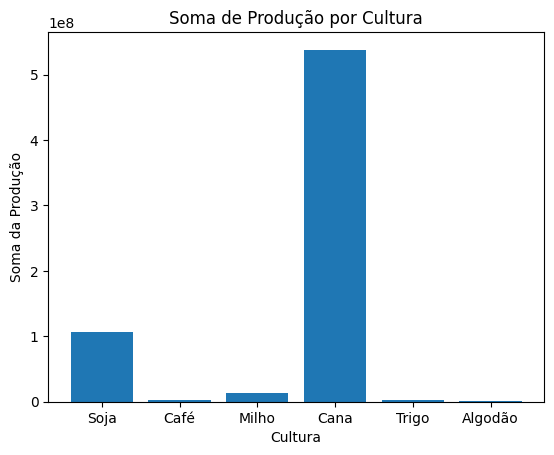

In [62]:
#Criando um dado com as informações acima para melhor visualização
somas = [soma_soja, soma_cafe, soma_milho, soma_cana, soma_trigo, soma_algodao]
culturas = ['Soja', 'Café', 'Milho', 'Cana', 'Trigo', 'Algodão']

#Criando o gráfico de barras
plt.bar(culturas, somas)

#Configurando o título e os rótulos dos eixos
plt.title('Soma de Produção por Cultura')
plt.xlabel('Cultura')
plt.ylabel('Soma da Produção')

#Exibindo o gráfico
plt.show()

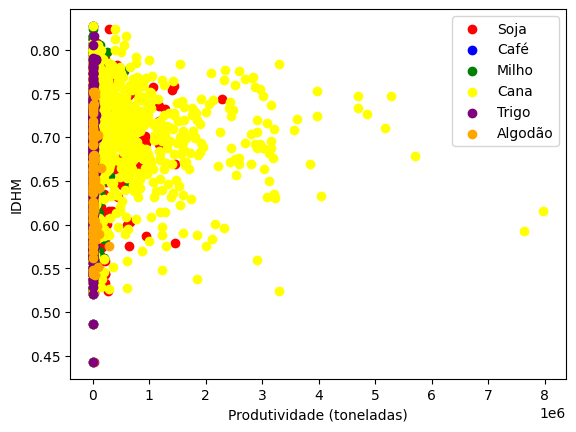

In [63]:
#Criando um novo dataframe com apenas as colunas relevantes para a analise
df_plot = IDHM_Prod_df[['IDHM', 'Prod_Soja', 'Prod_Cafe', 'Prod_Milho', 'Prod_Cana', 'Prod_Trigo', 'Prod_Algodao']]

#Criando o gráfico de dispersão com base em culturas separadas
plt.scatter(df_plot['Prod_Soja'], df_plot['IDHM'], color='red', label='Soja')
plt.scatter(df_plot['Prod_Cafe'], df_plot['IDHM'], color='blue', label='Café')
plt.scatter(df_plot['Prod_Milho'], df_plot['IDHM'], color='green', label='Milho')
plt.scatter(df_plot['Prod_Cana'], df_plot['IDHM'], color='yellow', label='Cana')
plt.scatter(df_plot['Prod_Trigo'], df_plot['IDHM'], color='purple', label='Trigo')
plt.scatter(df_plot['Prod_Algodao'], df_plot['IDHM'], color='orange', label='Algodão')
plt.xlabel('Produtividade (toneladas)')
plt.ylabel('IDHM')

#Exibindo o gráfico
plt.legend()
plt.show()


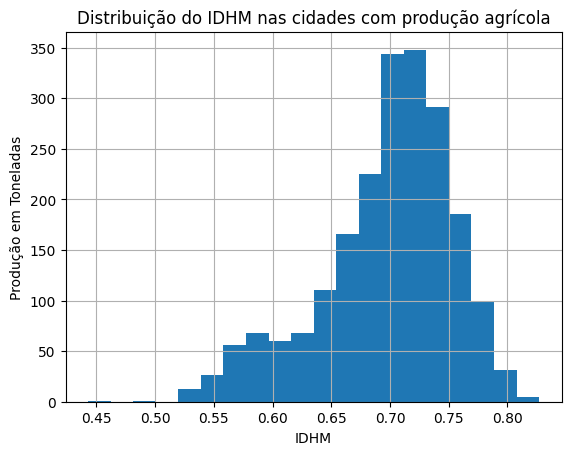

In [64]:
#Selecionando as colunas de produção por cultura
prod_cols = ['Prod_Soja', 'Prod_Cafe', 'Prod_Milho', 'Prod_Cana', 'Prod_Trigo', 'Prod_Algodao']

#Selecionando apenas as linhas que possuem produção em pelo menos uma das culturas
df_agricultura_ca = df_plot[df_plot[prod_cols].sum(axis=1) > 0]

#Plotando o histograma da distribuição do IDHM
df_agricultura_ca['IDHM'].hist(bins=20)
plt.title('Distribuição do IDHM nas cidades com produção agrícola')
plt.xlabel('IDHM')
plt.ylabel('Produção em Toneladas')

#Exibindo o gráfico
plt.show()

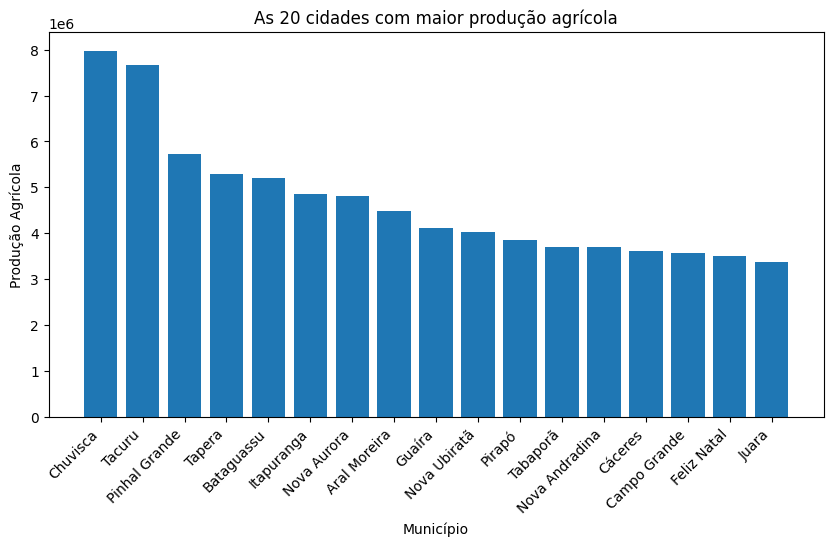

In [65]:
#Selecionando as 20 cidades com maior produção agrícola
topten_prod = IDHM_Prod_df.nlargest(20, 'Total_Prod')

#Criando o gráfico de barras
plt.figure(figsize=(10,5))
plt.bar(topten_prod['Municipio'], topten_prod['Total_Prod'])
plt.xticks(rotation=45, ha='right')
plt.xlabel('Município')
plt.ylabel('Produção Agrícola')
plt.title('As 20 cidades com maior produção agrícola')

#Exibindo o gráfico
plt.show()


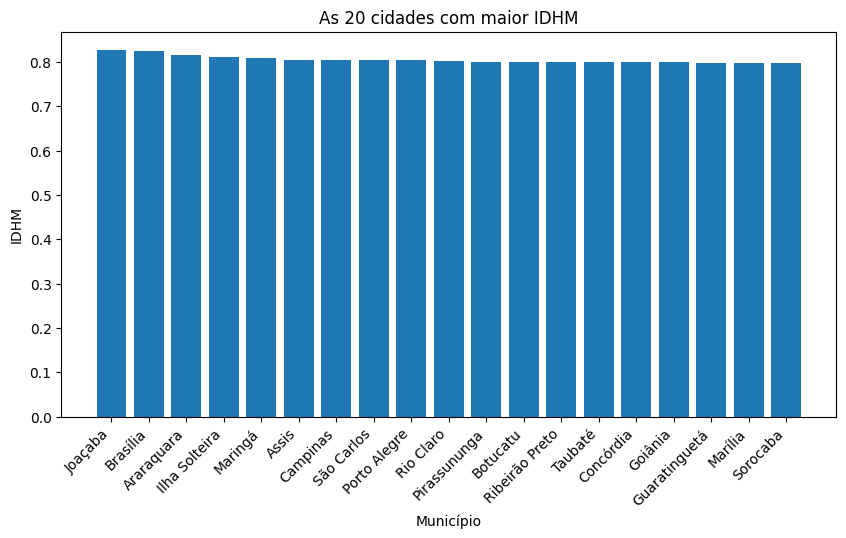

In [66]:
#Selecionando as 20 cidades com maior produção agrícola
topten_idhm = IDHM_Prod_df.nlargest(20, 'IDHM')

#Criando o gráfico de barras
plt.figure(figsize=(10,5))
plt.bar(topten_idhm['Municipio'], topten_idhm['IDHM'])
plt.xticks(rotation=45, ha='right')
plt.xlabel('Município')
plt.ylabel('IDHM')
plt.title('As 20 cidades com maior IDHM')

#Exibindo o gráfico
plt.show()

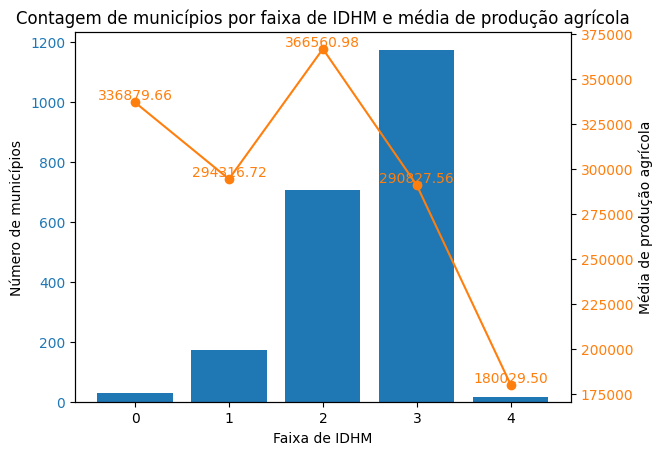

In [75]:
#Agrupando os dados por faixa de IDHM e calculando a média de produtividade agrícola para cada grupo
div_faixa_df = IDHM_Prod_df
means = div_faixa_df.groupby('IDHM_Faixa').mean()['Total_Prod']

#Contando o número de municípios em cada faixa de IDHM
counts = div_faixa_df['IDHM_Faixa'].value_counts()

#Criando uma figura com dois eixos y
fig, ax1 = plt.subplots()

#Configurando o primeiro eixo y para a contagem de municípios
ax1.set_xlabel('Faixa de IDHM')
ax1.set_ylabel('Número de municípios')
ax1.bar(counts.index, counts.values, color='C0')
ax1.tick_params(axis='y', labelcolor='C0')

#Configurando o segundo eixo y para a média de produtividade agrícola
ax2 = ax1.twinx()
ax2.set_ylabel('Média de produção agrícola')
ax2.plot(means.index, means.values, color='C1', marker='o')
ax2.tick_params(axis='y', labelcolor='C1')

# Adicionando o valor da média de produção para cada faixa
for i, mean in enumerate(means.values):
    ax2.text(i, mean, f'{mean:.2f}', ha='center', va='bottom', color='C1')

#Adicionando título
plt.title('Contagem de municípios por faixa de IDHM e média de produção agrícola')

#Mostrando o gráfico
plt.show()


No gráfico acima, podemos ver que cidades consideradas com nível muito baixo de desenvolvimento humano, detém uma produção agrícola relativamente alta quando se comparada com as cidades de nível baixo, alto e muito alto.

In [68]:
#Balanceamento da distribuição de classes usando Random Under-Sampling
#Carregando os dados
Balance_df = IDHM_Prod_df

#Definindo o limite para os valores do IDHM
threshold = 0.6

#Convertendo os valores do IDHM em rótulos binários
Balance_df['label'] = (Balance_df['IDHM'] < threshold).astype(int)
teste_dataset = IDHM_Prod_df.loc[IDHM_Prod_df.IDHM < threshold]

#Dividindo os dados em conjuntos de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(Balance_df.drop(['IDHM', 'label'], axis=1), Balance_df['label'], test_size=0.2, random_state=42)

#Combinando os conjuntos de treinamento e teste para codificação
combined = pd.concat([X_train, X_test], axis=0)

#Codificando as características categóricas
categorical_features = ['Municipio']
encoder = OrdinalEncoder(cols=categorical_features)
combined_encoded = encoder.fit_transform(combined)
combined_encoded = combined_encoded.fillna(0)  #Substituindo valores NaN por 0
X_train_encoded = combined_encoded[:len(X_train)]
X_test_encoded = combined_encoded[len(X_train):]

#Treinando um modelo de regressão logística
clf = LogisticRegression(random_state=42).fit(X_train_encoded, y_train)

#Balanceando a distribuição de classes usando Random Under-Sampling
rus = RandomUnderSampler(random_state=42)
X_train_resampled, y_train_resampled = rus.fit_resample(X_train_encoded, y_train)

#Treinando um modelo de regressão logística nos dados reamostrados. 
clf_resampled = LogisticRegression(random_state=42).fit(X_train_resampled, y_train_resampled)

#Avaliando os modelos
y_pred = clf.predict(X_test_encoded)
y_pred_resampled = clf_resampled.predict(X_test_encoded)

#Mostrando os resultados
print("Accuracy (unbalanced):", accuracy_score(y_test, y_pred))
print("F1 Score (unbalanced):", f1_score(y_test, y_pred))
print("Accuracy (balanced):", accuracy_score(y_test, y_pred_resampled))
print("F1 Score (balanced):", f1_score(y_test, y_pred_resampled))


Accuracy (unbalanced): 0.919047619047619
F1 Score (unbalanced): 0.0
Accuracy (balanced): 0.8261904761904761
F1 Score (balanced): 0.17977528089887643


/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Realizei o balanceamento das classes e utilizamos a regressão logistica para validação do balanceamento, o que nos mostrou que, os dados balanceados estão "piores" que os desbalanceados. Desta forma, considerei manter o treinamento nos modelos utilizando os dados originais desbalanceados.

In [69]:
#Decision Tree Classifier
#Carregando os dados
Decision_df = IDHM_Prod_df

#Definindo o limiar para os valores de IDHM (com base no histograma, tentei usar maior que 0.60 para normalizar a curva)
threshold = 0.6
print(f'tamanho do dado: {len(Decision_df)}')

#Selecionando as variáveis explicativas (X) e a variável resposta (y)
X = Decision_df[['Prod_Soja', 'Prod_Cafe', 'Prod_Milho', 'Prod_Cana', 'Prod_Trigo', 'Prod_Algodao']].values
y = Decision_df['IDHM_Faixa'].values

#Dividindo os dados em conjuntos de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Combinando os conjuntos de treino e teste para a codificação
combined = pd.concat([pd.DataFrame(X_train), pd.DataFrame(X_test)], axis=0)

print(f'tamanho do dado X_train: {len(X_train)}')
print(f'tamanho do dado X_test: {len(X_test)}')

#Codificando as variáveis categóricas
encoder = OrdinalEncoder()
combined_encoded = encoder.fit_transform(combined.drop(combined.columns[0], axis=1))
combined_encoded = combined_encoded.fillna(0)  # Replace NaN values with 0
X_train_encoded = combined_encoded[:len(X_train)]
X_test_encoded = combined_encoded[len(X_train):]

#Treinando um modelo classificador de árvore de decisão
clf = DecisionTreeClassifier(random_state=42).fit(X_train_encoded, y_train)

#Balanceando a distribuição de classes usando Random Under-Sampling
rus = RandomUnderSampler(random_state=42)
X_train_resampled, y_train_resampled = rus.fit_resample(X_train_encoded, y_train)

#Treinando um modelo classificador de árvore de decisão nos dados balanceados
clf_resampled = DecisionTreeClassifier(random_state=42).fit(X_train_resampled, y_train_resampled)

print(f'tamanho do dado Xtrain_resampled: {len(X_train_resampled)}')
print(f'tamanho do dado Y_train_resampled: {len(y_train_resampled)}')

#Avaliando os modelos
y_pred = clf.predict(X_test_encoded)
y_pred_resampled = clf_resampled.predict(X_test_encoded)

#Mostrando os resultados
print(f'tamanho do dado y_pred: {len(y_pred)}')
print(f'tamanho do dado y_pred_resampled: {len(y_pred_resampled)}')
print("Accuracy (unbalanced):", accuracy_score(y_test, y_pred))
print("F1 Score (unbalanced):", f1_score(y_test, y_pred, average=None))
print("Accuracy (balanced):", accuracy_score(y_test, y_pred_resampled))
print("F1 Score (balanced):", f1_score(y_test, y_pred_resampled, average='macro'))

tamanho do dado: 2098
tamanho do dado X_train: 1678
tamanho do dado X_test: 420
tamanho do dado Xtrain_resampled: 40
tamanho do dado Y_train_resampled: 40
tamanho do dado y_pred: 420
tamanho do dado y_pred_resampled: 420
Accuracy (unbalanced): 0.42857142857142855
F1 Score (unbalanced): [0.         0.23255814 0.30496454 0.56950673 0.        ]
Accuracy (balanced): 0.2357142857142857
F1 Score (balanced): 0.1798724273432178


In [70]:
#KNN KNeighborsRegressor

#Carregando os dados
df = IDHM_Prod_df

print(f'tamanho do DF: {len(IDHM_Prod_df)}')
#Preenchendo todos os valores nulos com 0.
df.fillna(0,inplace=True)

#Selecionando as variáveis explicativas (X) e a variável resposta (y)
X = df[['Prod_Soja', 'Prod_Cafe', 'Prod_Milho', 'Prod_Trigo', 'Prod_Algodao']].values
y = df['IDHM_Faixa'].values

#Dividindo os dados em conjuntos de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Padronizando as variáveis explicativas
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

#Criando o modelo KNN com Regressão
knn = KNeighborsRegressor(n_neighbors=20, weights='distance')

#Treinando o modelo
knn.fit(X_train, y_train)

#Fazendo as previsões
y_pred = knn.predict(X_test)
print(y_pred)
print(y_test)

#Calculando o erro do modelo
mse = ((y_pred - y_test) ** 2).mean()

#Calculando o coeficiente de determinação (R²)
r2 = r2_score(y_test, y_pred)

print('Erro médio quadrático:', mse)
y_pred_quantizado = [ int(round(x)) for x in y_pred]

#Calculando o percentual de acerto
acerto = [1 if x ==y else 0 for x,y in zip(y_test, y_pred_quantizado)]

#Mostrando os resultados
print(len(acerto))
print(len(df))
print(f'Percentual de acerto:{sum(acerto)/len(acerto)}')
print('Coeficiente de determinação (R²):', r2)

tamanho do DF: 2098
[2.         3.         2.10910841 2.         3.         2.04596416
 2.66696911 2.5632369  2.33677424 2.49731141 2.2676256  3.
 2.17198889 2.58353553 2.46660089 2.45910495 2.96194983 2.48293374
 1.95049071 2.37012808 2.69406563 2.91574801 2.57856998 2.
 2.62985349 2.6183349  2.92667456 2.4327228  2.54091887 2.42383876
 2.23536199 2.56766315 2.33701789 2.8157255  3.         2.5
 2.94298583 2.78523284 2.30625965 2.5919169  2.49985869 2.25132552
 2.08140207 2.38008248 2.0104309  2.94871704 2.70318644 2.21975733
 2.27758191 2.85204446 2.44482128 2.         2.59700097 2.77635581
 2.73205596 3.         2.27037582 2.92985445 2.78461823 2.66633353
 2.17752051 2.76242897 2.2259663  3.         2.26429427 2.8356145
 3.         2.3443456  3.08983835 2.36435813 1.91913358 2.39051394
 2.21121565 3.         2.28623185 2.34751196 2.80913008 2.02998505
 2.64685997 2.02014013 2.19149688 2.36058431 2.2162457  2.86364843
 2.11678475 2.66093728 2.64300421 3.         2.15090775 2.
 2.5273

In [71]:
#SVM

#Carregando os dados em um dataframe pandas
SVM_df = IDHM_Prod_df

#Removendo as colunas irrelevantes
SVM_df.drop(['Municipio'], axis=1, inplace=True)

#Preenchendo valores NaN
SVM_df.fillna(SVM_df.mean(), inplace=True)

#Dividindo os dados em X e Y
X = SVM_df.drop('IDHM_Faixa', axis=1)
Y = SVM_df['IDHM_Faixa']

#Dividindo os dados em treinamento e teste
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

#Padronizando os dados
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Criando um modelo SVM 
model = SVC(kernel='linear', C=1, random_state=42)

#Treinando o modelo SVM
model.fit(X_train, Y_train)

#Fazendo previsões usando o modelo SVM
Y_pred = model.predict(X_test)

#Avaliando a precisão do modelo SVM
print('Accuracy score:', accuracy_score(Y_test, Y_pred))
print('Precision score:', precision_score(Y_test, Y_pred, average='macro'))
print('Recall score:', recall_score(Y_test, Y_pred, average='macro'))


Accuracy score: 0.9650793650793651
Precision score: 0.5813487881981032
Recall score: 0.5936363636363636


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


As classes não tem correlação entre elas como vimos e a caracteristicas dos dados é que eles são linearmentes separaveis por hiperplanos. Nenhuma cidade no caso é altamente produtiva em todas as culturas. A opção do kernel linear já demostra uma excelente acurácia não sendo necessário a utilização de kernel mais complexos.


#Decision Tree Classifier
Accuracy (unbalanced): 0.42857142857142855<br>
F1 Score (unbalanced): [0.         0.23255814 0.30496454 0.56950673 0.        ]<br>
Accuracy (balanced): 0.2357142857142857<br>
F1 Score (balanced): 0.1798724273432178<br>

<br><br>
#KNN
Erro médio quadrático: 0.5532621377207045<br>
Percentual de acerto:0.5047619047619047<br>
Coeficiente de determinação (R²): -0.11262986335368974<br>
<br><br>

#SVM
Accuracy score: 0.9650793650793651<br>
Precision score: 0.5813487881981032<br>
Recall score: Recall score: 0.5936363636363636<br>
